# Travaux Dirigés: Mining stable patterns in complex data

# Part 0. Usefull functions

Import everythin that should be imported

In [114]:
# Basic python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# FCA packages
import caspailleur as csp
from paspailleur import pattern_structures as PS

from fcapy.poset import POSet
from fcapy.visualizer import LineVizNx
from fcapy.utils.utils import powerset

# Text specific packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Packages for minor usage
from tqdm.notebook import tqdm
import re
import requests
import textwrap

[nltk_data] Downloading package punkt to /Users/chizhia1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chizhia1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define the functions we will use for visualizing the concepts with line diagrams

In [115]:
def wrap_text_lines(lines, width):
  """Find long lines of text and split them into shorter lines of text"""
  return [sub_line for line in lines
          for sub_line in textwrap.wrap(line, width, break_long_words=False)]


def concept_label_func(
    el_i, poset, patterns_df, intent_to_strings_func,
    reduce_intents=True, n_symbols_per_line=80,
) -> str:
  """Make a readable description of a concept based on its position in the poset


  Input
  -----
    el_i: int
      Index of a concept in the poset
    poset: fcapy.poset.POSet
      Partially Ordered Set containing all the concepts to visualize.
      The top elements of the poset should correspond to the most general concepts
    patterns_df: pd.DataFrame
      DataFrame containing some required properties of a poset like:
      'intents_verb' with readable description of concept's intent
      'support' and 'delta_measure' with the values for concept's support and delta-measure
    reduce_intents: bool
      A flag whether to use the reduced notation of concept's intent
      That is, whether or not to drop the concept's attribute shared by more general concepts
    n_symbols_per_line: int
      The maximal width of a single line of text in the label

  Output
  ------
  label: str
    A human readable descriptoin of a concept for a line diagram

  """

  intent, support, delta = patterns_df.loc[el_i, ['intents_verb', 'support', 'delta_measure']]
  parents_intents = [patterns_df.at[parent_i, 'intents_verb'] for parent_i in poset.parents(el_i)]

  top_label = intent_to_strings_func(intent, parents_intents, reduce_intents)
  bottom_label = [f"Supp: {support}", f'$\Delta$: {delta}']
  top_label, bottom_label = [wrap_text_lines(label, n_symbols_per_line) for label in [top_label, bottom_label]]

  if len(top_label) < len(bottom_label):
    top_label = [''] * (len(bottom_label)-len(top_label)) + top_label
  if len(bottom_label) < len(top_label):
    bottom_label += [''] * (len(top_label)-len(bottom_label))
  label = '\n'.join(top_label) + '\n\n' + '\n'.join(bottom_label)
  return label

In [116]:
def intent_to_strings_binary(intent, parents_intents, reduce_intents=True):
  """Convert the formal intent into a readable string"""
  if reduce_intents:
    for parent_intent in parents_intents:
      parent_intent = set(parent_intent)
      intent = [m for m in intent if m not in parent_intent]
  return [', '.join(intent)]

In [117]:
def intent_to_strings_tabular(intent, parents_intents, pattern_structure, column_names, reduce_intents=True):
  """Convert the tabular intent into a readable string"""
  if reduce_intents:
    for parent_intent in parents_intents:
      intent = {m: pattern for m, pattern in intent.items() if pattern != parent_intent[m]}

      for m, pattern in intent.items():
        column_i = column_names.index(m)
        column_structure = pattern_structure.basic_structures[column_i]

        if isinstance(column_structure, PS.IntervalPS):
          intent[m] = [a if a != b else ... for a, b in zip(pattern, parent_intent[m])]

    intent = {m: pattern for m, pattern in intent.items()
      if pattern != [..., ...] and  pattern != frozenset()}


  intent_strings = []
  for m, pattern in intent.items():
    pattern_str = '{'+', '.join(pattern)+'}' if type(pattern) == frozenset else pattern
    pattern_str = f"{m}: {pattern_str};"
    pattern_str = pattern_str.replace('Ellipsis', '...').replace('(', '[').replace(')', ']')
    intent_strings.append(pattern_str)

  return intent_strings

In [118]:
def intent_to_strings_ngram(intent, parents_intents, reduced_intents=True) -> str:
  """Convert the ngram intent into a readable string"""
  if reduced_intents:
    for parent_intent in parents_intents:
      parent_intent = set(parent_intent)
      intent = [ngram for ngram in intent if ngram not in parent_intent]

  intent_strings = [ngram+';' for ngram in intent]
  return intent_strings

# Part 1. Stable formal concepts

## 1.1 Load the data, compute the concepts

Let us consider Bob Ross paintings dataset from the previous TD.

In [119]:
blog_features = pd.read_csv('features_aggregated.csv', sep="\t")
binary_features = blog_features.drop(columns=['Unnamed: 0', 'author_id'])
binary_features.head()

,occupation_Accounting,occupation_Advertising,occupation_Agriculture,occupation_Architecture,occupation_Arts,occupation_Automotive,occupation_Banking,occupation_Biotech,occupation_BusinessServices,occupation_Chemicals,...,"irony_(-0.001, 0.2]","irony_(0.2, 0.4]","irony_(0.4, 0.6]","irony_(0.6, 0.8]","irony_(0.8, 1.0]","sarcasm_(-0.001, 0.2]","sarcasm_(0.2, 0.4]","sarcasm_(0.4, 0.6]","sarcasm_(0.6, 0.8]","sarcasm_(0.8, 1.0]"
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [120]:
# trying to drop the topics
# topic_columns = [col for col in binary_features.columns if 'topic' in col]
binary_features.drop(columns=['topic_7', 'topic_12', 'topic_14'], inplace=True)

And let us find the concepts in the data

In [121]:
%%time
itemsets_ba = csp.np2bas(binary_features.values)
intents_ba = csp.list_intents_via_LCM(itemsets_ba, min_supp = 0.03)
print(len(intents_ba))

4663
CPU times: user 892 ms, sys: 261 ms, total: 1.15 s
Wall time: 1.17 s


In [122]:
def node_label_func(el_i, intents_, extents_):
  intent = intents_[el_i]
  intent = intent if intent != '' else r'$\emptyset$'

  extent = extents_[el_i]
  extent = extent if extent != '' else r'$\emptyset$'
  return f"{intent}\n\n{extent}"

Let us compute the stable extents via Sofia

In [123]:
attr_extents = csp.np2bas(binary_features.values.T)

stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_sofia(
    attr_extents, n_stable_extents=1000,
    use_tqdm=True, n_attributes=len(attr_extents)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count())
print(len(stable_extents))

  0%|          | 0/129 [00:00<?, ?it/s]

999


Compute the stable intents based on the given stable extents

In [124]:
stable_extents_isets = list(csp.base_functions.bas2isets(stable_extents))
attr_extents_isets = list(csp.base_functions.bas2isets(attr_extents))

stable_intents = [list(csp.base_functions.intention(extent, attr_extents_isets))
                  for extent in stable_extents_isets]

Put everything into a Pandas DataFrame for manual analysis

In [125]:
patterns_df = pd.DataFrame()
patterns_df['extents'] = stable_extents_isets
patterns_df['intents'] = stable_intents
patterns_df['intents_verb'] = [list(binary_features.columns[intent]) for intent in stable_intents]
patterns_df['support'] = [len(extent) for extent in stable_extents_isets]
patterns_df['delta_measure'] = list(csp.indices.delta_stability_index(stable_extents))

patterns_df.head()

,extents,intents,intents_verb,support,delta_measure
0,"(12803, 5640, 1545, 4106, 13833, 11276, 12813,...","[81, 105, 111, 125]","[token_count_(300.0, 450.0], punct_per_sents_(...",189,189
1,"(15361, 14345, 15370, 17931, 17422, 12304, 102...","[86, 105, 111, 117, 125]","[sent_count_(-0.001, 15.0], punct_per_sents_(-...",190,190
2,"(6146, 1539, 9731, 11269, 7174, 12806, 13832, ...","[58, 105, 111, 117, 121, 124]","[topic_21, punct_per_sents_(-0.001, 1.0], punc...",192,192
3,"(2053, 6, 5131, 5135, 13328, 12305, 16920, 105...","[87, 93, 101, 105, 111, 114, 119, 124]","[sent_count_(15.0, 30.0], pron_per_sents_(-0.0...",194,194
4,"(18432, 10755, 12803, 5640, 17418, 3083, 2061,...","[93, 105, 111, 120, 125]","[pron_per_sents_(-0.001, 1.0], punct_per_sents...",194,194


In [126]:
patterns_df.shape

(999, 5)

In [127]:
def find_zodiac(intents_verb):
    for verb in intents_verb:
        if 'zodiac' in verb:
            return 1
    return 0

In [128]:
patterns_df['zodiac_flag'] = patterns_df.intents_verb.apply(find_zodiac)

In [129]:
patterns_df['zodiac_flag'].value_counts()

zodiac_flag
0    828
1    171
Name: count, dtype: int64

## 1.4 Select the most interesting concepts

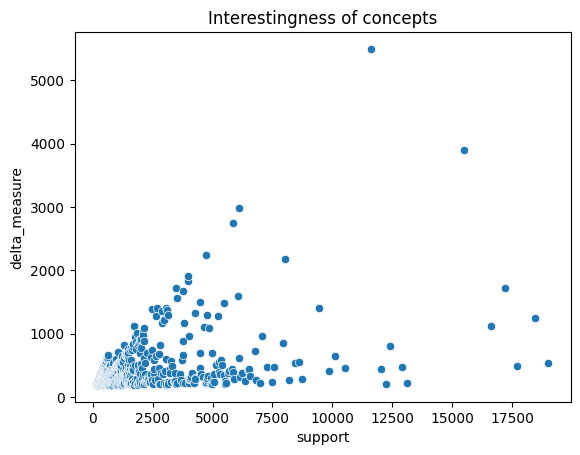

In [130]:
sns.scatterplot(x=patterns_df['support'], y=patterns_df['delta_measure'])
plt.title('Interestingness of concepts')
plt.show()

In [131]:
patterns_df[(patterns_df['support']>50)&(patterns_df['delta_measure']>10)].head(10)

,extents,intents,intents_verb,support,delta_measure,zodiac_flag
0,"(12803, 5640, 1545, 4106, 13833, 11276, 12813,...","[81, 105, 111, 125]","[token_count_(300.0, 450.0], punct_per_sents_(...",189,189,0
1,"(15361, 14345, 15370, 17931, 17422, 12304, 102...","[86, 105, 111, 117, 125]","[sent_count_(-0.001, 15.0], punct_per_sents_(-...",190,190,0
2,"(6146, 1539, 9731, 11269, 7174, 12806, 13832, ...","[58, 105, 111, 117, 121, 124]","[topic_21, punct_per_sents_(-0.001, 1.0], punc...",192,192,0
3,"(2053, 6, 5131, 5135, 13328, 12305, 16920, 105...","[87, 93, 101, 105, 111, 114, 119, 124]","[sent_count_(15.0, 30.0], pron_per_sents_(-0.0...",194,194,0
4,"(18432, 10755, 12803, 5640, 17418, 3083, 2061,...","[93, 105, 111, 120, 125]","[pron_per_sents_(-0.001, 1.0], punct_per_sents...",194,194,0
5,"(514, 6147, 1030, 1542, 7176, 1037, 8205, 1435...","[58, 80, 93, 105, 111, 120, 124]","[topic_21, token_count_(150.0, 300.0], pron_pe...",195,195,0
6,"(514, 6147, 518, 1030, 1542, 7176, 8205, 14352...","[58, 80, 86, 105, 111, 120, 124]","[topic_21, token_count_(150.0, 300.0], sent_co...",195,195,0
7,"(16384, 6145, 1538, 17411, 1030, 8205, 11278, ...","[34, 86, 93, 105, 111, 117, 120, 124]","[occupation_Student, sent_count_(-0.001, 15.0]...",200,200,0
8,"(18436, 5131, 11283, 10772, 8213, 1050, 4634, ...","[39, 93, 101, 105, 111, 114, 119, 124]","[occupation_indUnk, pron_per_sents_(-0.001, 1....",203,203,0
9,"(12802, 9219, 18437, 15368, 11274, 11789, 9744...","[67, 81, 105, 111, 124]","[zodiac_sign_Aquarius, token_count_(300.0, 450...",210,210,1


Merge support and delta-measure by multiplying them into a new interestingness measure

In [132]:
patterns_df['interestingness'] = patterns_df['support'] * patterns_df['delta_measure'] 
patterns_df['interestingness_zs'] = patterns_df['support'] * patterns_df['delta_measure'] * patterns_df['zodiac_flag']

## 1.5 Visualize the most interesting concepts

In [133]:
best_patterns = patterns_df.sort_values('interestingness', ascending=False).head(20).reset_index(drop=True)
best_patterns

,extents,intents,intents_verb,support,delta_measure,zodiac_flag,interestingness,interestingness_zs
0,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16...","[93, 105, 111, 124]","[pron_per_sents_(-0.001, 1.0], punct_per_sents...",11603,5497,0,63781691,0
1,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[105, 111, 124]","[punct_per_sents_(-0.001, 1.0], punct_per_toke...",15496,3893,0,60325928,0
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[111, 124]","[punct_per_tokens_(-0.001, 0.1], sarcasm_(-0.0...",17211,1715,0,29516865,0
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[111],"[punct_per_tokens_(-0.001, 0.1]]",18450,1239,0,22859550,0
4,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[105, 111]","[punct_per_sents_(-0.001, 1.0], punct_per_toke...",16609,1113,0,18485817,0
5,"(1, 2, 4, 5, 6, 8, 13, 14, 15, 16, 19, 22, 23,...","[93, 101, 105, 111, 124]","[pron_per_sents_(-0.001, 1.0], pron_per_tokens...",6106,2988,0,18244728,0
6,"(0, 1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 19, 2...","[86, 105, 111, 124]","[sent_count_(-0.001, 15.0], punct_per_sents_(-...",8042,2183,0,17555686,0
7,"(0, 1, 2, 4, 5, 7, 8, 9, 12, 13, 14, 19, 21, 2...","[86, 93, 105, 111, 124]","[sent_count_(-0.001, 15.0], pron_per_sents_(-0...",5859,2741,0,16059519,0
8,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17...","[86, 111, 124]","[sent_count_(-0.001, 15.0], punct_per_tokens_(...",9441,1399,0,13207959,0
9,"(16384, 16387, 16389, 16393, 10, 16394, 16395,...","[102, 105, 111, 124]","[pron_per_tokens_(0.05, 0.075], punct_per_sent...",4716,2248,0,10601568,0


### Default set of best patterns

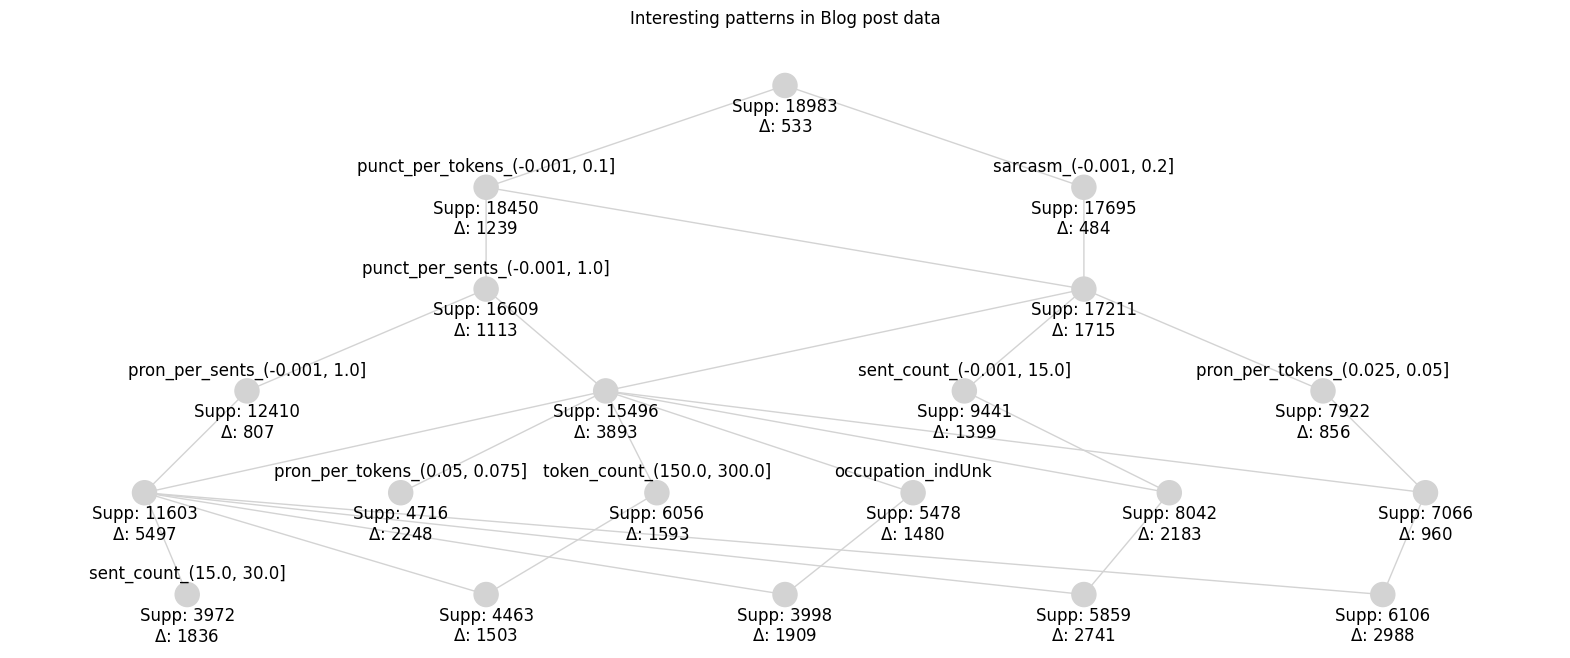

In [135]:
poset = POSet(best_patterns['extents'])

fig, ax = plt.subplots(figsize=(20,8))

node_label_func_binary = lambda el_i, P: concept_label_func(el_i, P, best_patterns, intent_to_strings_binary)
viz = LineVizNx()
viz.draw_poset(
        poset, ax=ax,
        node_label_func = node_label_func_binary
)
plt.title('Interesting patterns in Blog post data')
plt.show()

### Only patterns that involve Zodiac signs

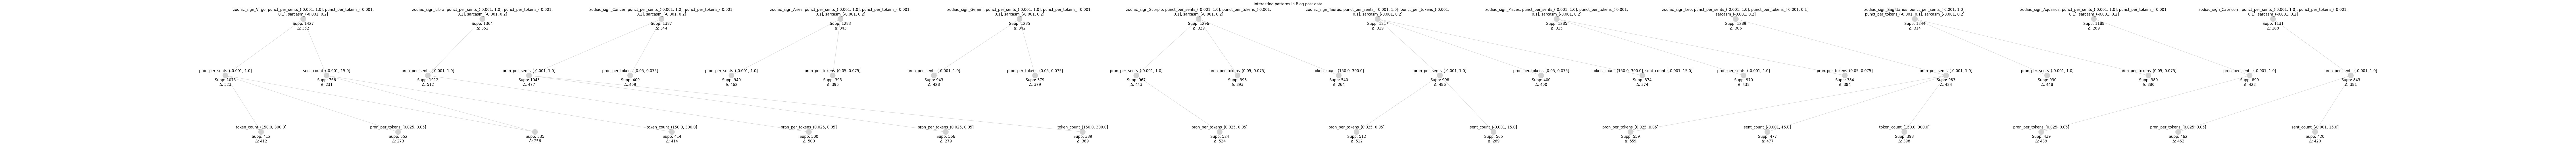

In [162]:
best_patterns = patterns_df.sort_values('interestingness_zs', ascending=False).head(50).reset_index(drop=True)

poset = POSet(best_patterns['extents'])

fig, ax = plt.subplots(figsize=(150,8))

node_label_func_binary = lambda el_i, P: concept_label_func(el_i, P, best_patterns, intent_to_strings_binary)
viz = LineVizNx()
viz.draw_poset(
        poset, ax=ax,
        node_label_func = node_label_func_binary
)
plt.title('Interesting patterns in Blog post data')
plt.show()

# Classification 

SVM algorithm that predicts the Zodiac sign based on our features

In [169]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report

In [155]:
# encode the Zodiac sign back to categorical
zs_columns = [col for col in binary_features.columns if 'zodiac' in col]

In [158]:
y = pd.from_dummies(binary_features[zs_columns])
X = binary_features.drop(columns=zs_columns)

In [159]:
X.shape, y.shape

((18983, 117), (18983, 1))

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [167]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)

/Users/chizhia1/Documents/Data Mining Project/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(decision_function_shape='ovo')

In [168]:
y_pred = clf.predict(X_test)

In [171]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

   zodiac_sign_Aquarius       0.06      0.01      0.02       484
      zodiac_sign_Aries       0.08      0.05      0.06       514
     zodiac_sign_Cancer       0.09      0.20      0.12       548
  zodiac_sign_Capricorn       0.06      0.02      0.03       443
     zodiac_sign_Gemini       0.07      0.05      0.06       527
        zodiac_sign_Leo       0.10      0.07      0.08       527
      zodiac_sign_Libra       0.10      0.10      0.10       577
     zodiac_sign_Pisces       0.10      0.07      0.08       512
zodiac_sign_Sagittarius       0.10      0.06      0.08       504
    zodiac_sign_Scorpio       0.07      0.07      0.07       522
     zodiac_sign_Taurus       0.10      0.09      0.09       524
      zodiac_sign_Virgo       0.10      0.25      0.14       583

               accuracy                           0.09      6265
              macro avg       0.08      0.09      0.08      6265
           weighted avg